In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.signal import wiener
from soundfile import SoundFile as sf
from spleeter.separator import Separator

In [ ]:
# Я взял по 1 примеру из каждого датасета
engine_file = 'Engine.wav'
voice_file = 'Voice.wav'
bird_file = 'Bird.wav'

# Загрузка аудиофайлов
target_sr = 22000 # `sr` частота дискретизации
engine_signal, sr_engine = librosa.load(engine_file, sr=target_sr)
voice_signal, sr_voice = librosa.load(voice_file, sr=target_sr)
bird_signal, sr_bird = librosa.load(bird_file, sr=target_sr)

print(f"Engine: Длительность = {len(engine_signal) / sr_engine:.2f} сек")
print(f"Voice: Длительность = {len(voice_signal) / sr_voice:.2f} сек")
print(f"Bird: Длительность = {len(bird_signal) / sr_bird:.2f} сек")

Engine: Длительность = 5.00 сек
Voice: Длительность = 4.07 сек
Bird: Длительность = 0.21 сек


# Часть 1

In [ ]:
def Spectrogram(window_size, hop_size, window_type, n_fft, signal):
  # Расчет STFT (Кратковременное преобразование Фурье)
  stft_result = librosa.stft(signal, n_fft=n_fft, hop_length=hop_size, window=window_type)

  # Преобразование амплитуды в dB для удобства визуализации
  stft_db = librosa.amplitude_to_db(abs(stft_result), ref=np.max)

  # Визуализация спектрограммы
  plt.figure(figsize=(12, 6))
  librosa.display.specshow(stft_db, sr=sr_engine, hop_length=hop_size, x_axis='time', y_axis='log')
  plt.colorbar(format="%+2.0f dB")
  plt.title('Спектрограмма')
  plt.xlabel("Время (секунды)")
  plt.ylabel("Частота (Hz)")
  plt.show()

Размер окна: <br> Количество семплов, которое анализируется за один раз. Чем больше окно, тем больше частот мы различаем, но при этом теряется информация о том, как меняется сигнал между окнами. У меньших окон наоборот: точность в частотной области снижается, но лучше улавливаются изменения во времени. <br>

Шаг окна: <br> То, на сколько семплов мы перемещаем окно за раз. Чем меньше шаг (в % от размера окна), тем точнее мы видим изменения во времени, но это увеличивает вычислительную нагрузку. <br>

Тип окна:<br> Функция для сглаживания краев окна, чтобы не терять информацию на границах (утечка спектра). Примеры: Ханн, Хэмминг и другие. <br>

Количество коэффициентов Фурье:<br> Это количество частотных точек, которые вычисляются при анализе каждого окна. Если это значение больше или равно размеру окна, то мы получаем больше частотных данных, что позволяет лучше различать высокие частоты. <br>

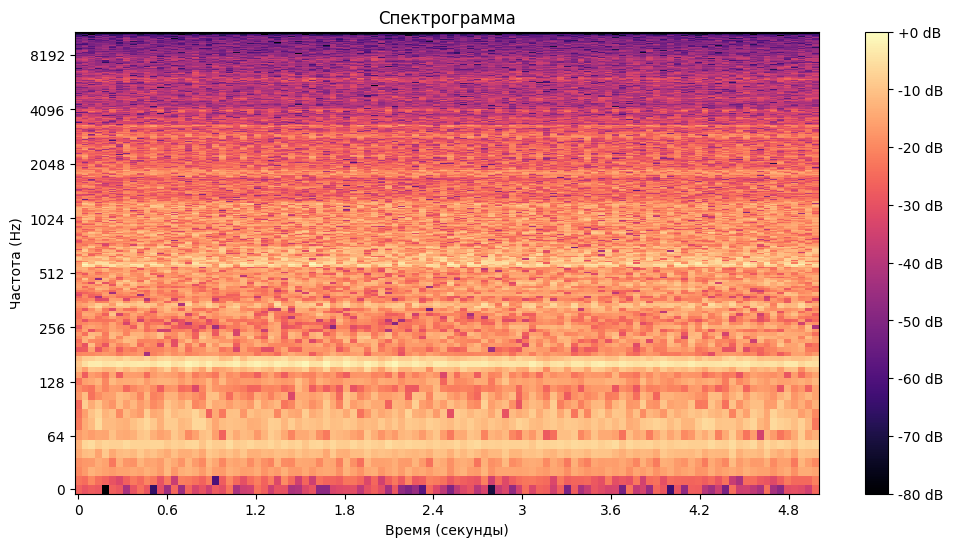

In [ ]:
Spectrogram(2048, 1024, 'hann', 2048, engine_signal)

# Так как шум двигателя состоит из низкочастотных и стабильных компонентов, можно использовать более крупное окно.
# Шаг окна в 1024 семпла выбран как компромисс между точностью и скоростью обработки, учитывая особенности сигнала.
# Оконная функция Ханна выбрана, так как она хорошо сглаживает края сигнала, минимизируя спектральные утечки.

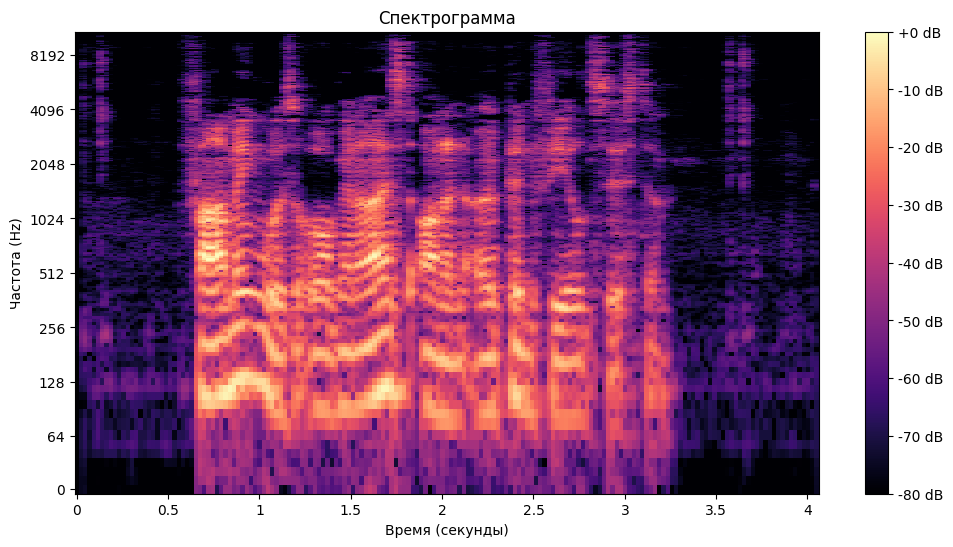

In [ ]:
Spectrogram(2048, 512, 'hann', 2048, voice_signal)

# Человеческая речь содержит множество частотных компонентов и динамических изменений,
# поэтому выбрано окно размером 2048 сэмплов для обеспечения хорошего частотного разрешения.
# Шаг окна в 512 сэмплов был выбран для улучшения временного разрешения, позволяя точнее отразить изменения в сигнале.
# Оконная функция Ханна выбрана по тому же принципу, что и в предыдущем примере, для минимизации спектральных утечек.

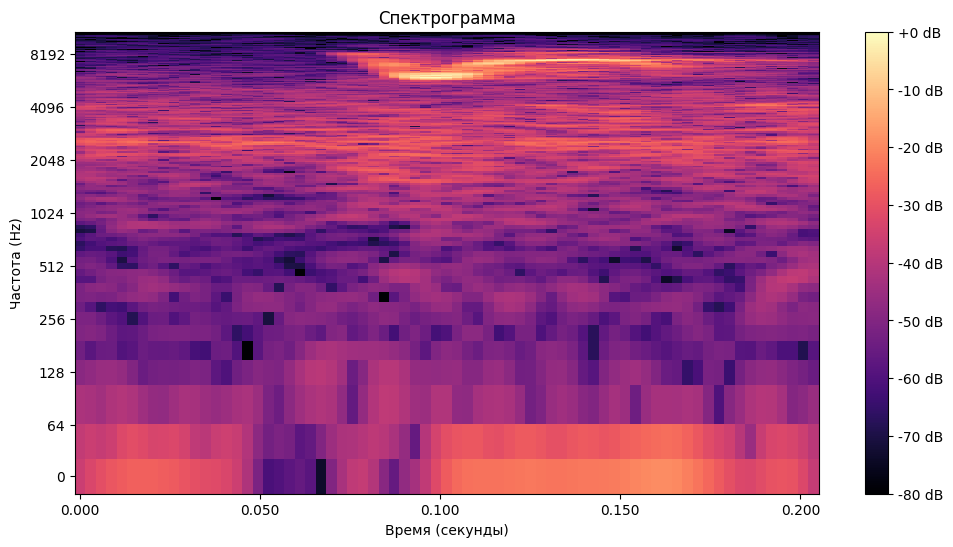

In [ ]:
Spectrogram(512, 64, 'hann', 512, bird_signal)

# Птичье пение характеризуется быстрыми изменениями частот и динамикой,
# поэтому размер окна в 512 сэмплов позволяет эффективно захватывать эти детали.
# Шаг окна в 64 сэмпла был выбран для обеспечения высокого временного разрешения,
# поскольку сигнал короткий и его характеристики быстро меняются.
# Оконная функция Ханна была выбрана по тому же принципу, что и в предыдущих примерах

Разные сигналы требуют различных параметров для анализа из-за их специфики. Например, в случае сигнала двигателя его частотные компоненты четко видны на спектрограмме, что позволяет использовать более длинные окна и меньший шаг (например, 4096 и 2024), обеспечивая высокую точность анализа. Речь, в отличие от механических звуков, характеризуется большим разнообразием частот и динамических изменений, что требует других параметров для эффективного анализа (например, 2048 и 512). <br> Таким образом, правильный выбор оптимальных параметров позволяет проводить анализ максимально эффективно.

# Часть 2


In [ ]:
birb_noise = None

# Добавление шума к речевым сигналам
def add_noise_to_signal(voice_signal, noise_signal):
    global birb_noise

    # Проверка на пустоту сигналов
    if voice_signal.size == 0 or noise_signal.size == 0:
        raise ValueError("Оба сигнала должны быть не пустыми.")

    # Если шум короче речевого сигнала, циклически повторяем его
    if len(noise_signal) < len(voice_signal):
        repeat_count = int(np.ceil(len(voice_signal) / len(noise_signal)))
        noise_signal = np.tile(noise_signal, repeat_count)
        birb_noise = noise_signal

    # Обрезаем шум до длины речевого сигнала, если он длиннее
    noise_signal = noise_signal[:len(voice_signal)]

    # Смешиваем шум и речевой сигнал
    noisy_signal = voice_signal + noise_signal

    return noisy_signal

speech_engine = add_noise_to_signal(voice_signal, engine_signal)
speech_bird = add_noise_to_signal(voice_signal, bird_signal)

In [ ]:
from IPython.display import Audio

# Воспроизведение зашумленного сигнала чтобы удостовреиться что все правильно заушмилось
Audio(speech_engine, rate=sr_voice)

In [ ]:
Audio(speech_bird, rate=sr_voice)

In [ ]:
# расчет SNR
def calculate_snr(clean_signal, noisy_signal):
    # Т.к. зашумленный сигнал был немного длиннее.
    min_length = min(len(clean_signal), len(noisy_signal))
    clean_signal = clean_signal[:min_length]
    noisy_signal = noisy_signal[:min_length]

    # Рассчитываем мощность очищенного сигнала и шума
    signal_power = np.sum(clean_signal ** 2)
    noise_power = np.sum((clean_signal - noisy_signal) ** 2)

    # Рассчитываем SNR
    snr = 10 * np.log10(signal_power / noise_power)

    return snr

In [ ]:
print(f"SNR для речи + двигателя: {calculate_snr(voice_signal, speech_engine)}")
print(f"SNR для речи + птиц: {calculate_snr(voice_signal, speech_bird)}")

SNR для речи + двигателя: 4.101777672767639
SNR для речи + птиц: 32.62850761413574


SNR для речи + двигателя: 4.1 дБ означает, что мощность шума близка к мощности полезного сигнала, однако наличие шума двигателя может частично искажать восприятие речи. <br> SNR для речи + птиц: 32.62 дБ указывает на то, что мощность полезного сигнала значительно превышает мощность шума. <br> В целом, эти цифры можно подтвердить эмпирически: речь плохо слышна в случае с шумом двигателя и хорошо различима при шуме птиц.

Для удаления шума из речевого сигнала я применил спектральное вычитание на каждом фрейме. Основная идея заключается в том, что мы вычитаем спектр шума из спектра зашумленного сигнала, чтобы получить чистый сигнал. Хотя можно вычитать средний спектр шума по нескольким фреймам, результаты этого подхода могут показывать более плохие результаты в некоторых случаях. Поэтому, для начала, я решил использовать спектральное вычитание на каждом фрейме. <br> Я выбрал именно метод спектрального вычитания, так как он прост в реализации и мне уже знаком.

In [ ]:
# Спектральное вычитание
def spectral_subtraction(noisy_signal, noise_signal, sr=22000, n_fft=2048, hop_length=512, neighbor_range=0):
    # Выполняем STFT для зашумленного и шумового сигналов
    noisy_stft = librosa.stft(noisy_signal, n_fft=n_fft, hop_length=hop_length)
    noise_stft = librosa.stft(noise_signal, n_fft=n_fft, hop_length=hop_length)

    num_frames = noisy_stft.shape[1]
    clean_stft = np.zeros_like(noisy_stft)

    for i in range(num_frames):
        # Определяем диапазон соседних кадров
        start_frame = max(0, i - neighbor_range)
        end_frame = min(num_frames - 1, i + neighbor_range)
        neighbor_frames = list(range(start_frame, end_frame + 1))

        if len(neighbor_frames) > 0:
            # Вычисляем среднюю мощность шума в соседних фреймах
            local_noise_power = np.mean(np.abs(noise_stft[:, neighbor_frames]), axis=1)
        else:
            local_noise_power = np.abs(noise_stft[:, i])

        # Вычисляем очищенный фрейм, вычитая мощность шума и восстанавливаем звук.
        clean_frame = np.where((np.abs(noisy_stft[:, i]) - local_noise_power) >= 0,
                               (np.abs(noisy_stft[:, i]) - local_noise_power),
                               0)
        clean_stft[:, i] = clean_frame * np.exp(1j * np.angle(noisy_stft[:, i]))

    # Обратное преобразование для получения очищенного сигнала
    clean_signal = librosa.istft(clean_stft, hop_length=hop_length)
    return clean_signal

clean_voice_e = spectral_subtraction(speech_engine, engine_signal)
clean_voice_b = spectral_subtraction(speech_bird, birb_noise)

In [ ]:
Audio(clean_voice_e, rate=sr_voice)

In [ ]:
Audio(clean_voice_b, rate=sr_voice)

In [ ]:
print(f"SNR для речи + двигателя: {calculate_snr(voice_signal, clean_voice_e)}")
print(f"SNR для речи + птиц: {calculate_snr(voice_signal, clean_voice_b)}")

SNR для речи + двигателя: 12.092773914337158
SNR для речи + птиц: 41.38229846954346


SNR для речи + двигателя: 12.09 дБ, что немного лучше по сравнению с исходным зашумленным сигналом (4.1 дБ). <br> SNR для речи + птиц: 41.38 дБ, что также выше, чем для зашумленного сигнала (32.62 дБ). <br>

Качество шумоподавления в случае с шумом птиц оказалось лучше, так как сам шум был тише и короче (я зациклил шум, если он был короче речевой дорожки). Результаты шумоподавления для двигателя также хорошие.

Так как не всегда имеется готовая дорожка шума, которую нужно вычитать, я попробовал использовать метод Винера для шумоподавления. Однако результаты фильтрации звука двигателя оказались неудовлетворительными. Метод Винера, который основан на статистических свойствах сигнала и шума, не смог эффективно удалить шум в данном случае.

In [ ]:
# Используем метод Винера для шумоподавления
filtered_signal = wiener(speech_engine)

Audio(filtered_signal, rate=22000)

Я подумал, что можно попробовать использовать это нейросетевое решение для задачи шумоподавления. В теории, если рассматривать шум как аккомпанемент, это может сработать для удаления нежелательного шума из речевых записей. Этот подход является экспериментальным, и его эффективность требует дальнейшей проверки. Spleeter, разработан для разделения аудиодорожек на вокал и аккомпанемент.

In [ ]:
sr = 22000

# Сохранение в WAV файл
sf.write('speech_engine.wav', speech_engine, sr)

In [ ]:
#!pip install spleeter

In [ ]:
# Инициализация Spleeter
separator = Separator('spleeter:2stems')  # 2stems для разделения на вокал и аккомпанемент

# Разделение аудиофайла
input_file = '/content/speech_engine.wav'
separator.separate_to_file(input_file, 'output/')

voice, sr = librosa.load('/content/output/speech_engine/vocals.wav', sr=22000)
car_noise, sr = librosa.load('/content/output/speech_engine/accompaniment.wav', sr=22000)

Audio(voice, rate=22000)

INFO:spleeter:File output/speech_engine/accompaniment.wav written succesfully
INFO:spleeter:File output/speech_engine/vocals.wav written succesfully


INFO:spleeter:File output/speech_engine/vocals.wav written succesfully
INFO:spleeter:File output/speech_engine/accompaniment.wav written succesfully


Хотя шум двигателя стал тише, я попробую улучшить результаты, используя спектральное вычитание, которое я реализовал ранее. В качестве источника шума я использую аккомпанемент, полученный в предыдущей ячейке.

In [ ]:
clean_voice_e_2 = spectral_subtraction(speech_engine, car_noise)
print("SNR:", calculate_snr(voice_signal, clean_voice_e_2))
Audio(clean_voice_e_2, rate=22000)

SNR: 5.337681770324707


Я не получил значительных изменений. По SBR (Signal-to-Background Ratio) наблюдается небольшая прибавка, что означает, что качество стало немного лучше.


---


Моя гипотеза заключалась в том, что можно взять аккомпанемент (шум), который я получил от модели для разделения трека, и с помощью функции спектрального вычитания вычесть средний шум по нескольким фреймам (neighbor_range) из шумового сигнала. Я ожидаю увидеть следующие результаты: при увеличении количества соседей в оригинальном шуме SNR будет падать, так как шум для спектрального вычитания будет менее похож на шум в зашумленной дорожке. В то же время в шуме, извлеченном через модель, я надеюсь увидеть небольшой прирост SNR. <br> Я рассчитаю SNR для значений neighbor_range = [0, 5, 10, 25, 50] и для разных пар: зашумленный сигнал и оригинальный шум, а также зашумленный сигнал и шум "аккомпанемент".

In [ ]:
neighbor_range = [0, 5, 10, 25, 50]

for n in neighbor_range:
    original = calculate_snr(voice_signal, spectral_subtraction(speech_engine, engine_signal, neighbor_range=n))
    accompaniment = calculate_snr(voice_signal, spectral_subtraction(speech_engine, car_noise, neighbor_range=n))

    print(f"SNR оригинальный шум neighbor_range={n}: {original}, SNR извлеченный шум neighbor_range={n}: {accompaniment}")


SNR оригинальный шум neighbor_range=0: 12.092773914337158, SNR извлеченный шум neighbor_range=0: 5.337681770324707
SNR оригинальный шум neighbor_range=5: 10.463740825653076, SNR извлеченный шум neighbor_range=5: 7.769007086753845
SNR оригинальный шум neighbor_range=10: 10.50187349319458, SNR извлеченный шум neighbor_range=10: 8.596441745758057
SNR оригинальный шум neighbor_range=25: 10.439784526824951, SNR извлеченный шум neighbor_range=25: 9.361980557441711
SNR оригинальный шум neighbor_range=50: 10.422202348709106, SNR извлеченный шум neighbor_range=50: 9.494346976280212


Как видно из метрик, моя гипотеза подтвердилась: при использовании оригинального шума SNR снизился на 1.5 и стал более стабильным на уровне 10.4. В то же время, при увеличении значения neighbor_range для извлеченного шума SNR вырос почти в два раза.

In [ ]:
!pip freeze > requirements.txt
